## Importing, cleaning, and wrangling data

In [118]:
import pandas as pd
import numpy as np
from pandas.api.types import CategoricalDtype
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.mosaicplot import mosaic

In [119]:
# import data with a context manager
with open("data_beta.csv") as fp:
    beta_df = pd.read_csv(fp) 

    names = beta_df['token'].tolist()
    
    # Drop columns that aren't the same as the ks data
    dropcol = ['first_name', 'last_name', 'google_email', 'smarthalo_email', 'smarthalo_versions', 'crowdfunded_smarthalo', 'submitted_date']
    beta_df.drop(columns= dropcol, inplace= True)

with open("data_ks.csv") as fp:
    ks_df = pd.read_csv(fp) 

    names.extend(ks_df['token'].tolist())
    
    # drop columns that aren't the same as the beta data
    dropcol2 = ['has_smarthalo_1', 'will_give_more_feedback', 'email', 'bad_column', 'submitted_date']
    ks_df.drop(columns= dropcol2, inplace= True)

#merge into one dataframe
df = pd.concat([beta_df, ks_df])

# convert to categorical data in the df
catcol = ["age", "gender", "platform", "income", "experience", "rides_per_week", "num_bikes_owned", "bike_cost", "location", "environment", 'accessory_factor' ]
for col in catcol:
    df[col] = df[col].astype('category')

print(df.info())
df.shape

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1836 entries, 0 to 1690
Data columns (total 20 columns):
age                     1836 non-null category
gender                  1836 non-null category
platform                1836 non-null category
income                  1836 non-null category
experience              1836 non-null category
rides_per_week          1836 non-null category
bike_type               1836 non-null object
num_bikes_owned         1836 non-null category
bike_cost               1836 non-null category
location                1836 non-null category
environment             1836 non-null category
companions              1836 non-null object
conditions              1836 non-null object
activities              1836 non-null object
reasons_to_bike         1836 non-null object
reasons_to_not_bike     1836 non-null object
reason_for_smarthalo    1836 non-null object
accessory_channels      1835 non-null object
accessory_factor        1835 non-null category
token           

(1836, 20)

In [120]:
for i in catcol:
    print(df[i].value_counts(dropna=False), '\n')

35-44 years    521
25-34 years    511
45-54 years    320
55+ years      317
0-25 years     111
45-45 years     56
Name: age, dtype: int64 

Male                 1557
Female                258
Non-binary             11
Prefer not to say      10
Name: gender, dtype: int64 

iOS        1047
Android     789
Name: platform, dtype: int64 

40,000 - 79,000 / year    618
80,000+ / year            615
0 - 39,999 / year         324
Prefer not to say         279
Name: income, dtype: int64 

8     523
7     496
6     259
9     215
5     125
10    123
4      51
3      23
2      12
1       9
Name: experience, dtype: int64 

3 or more times a week    1047
1-2 times a week           548
Less than once a week      241
Name: rides_per_week, dtype: int64 

1       734
2       644
3+      447
None     11
Name: num_bikes_owned, dtype: int64 

1000 - 2000      597
500 - 1000       535
2000 - 4000      338
100 - 500        218
4000+            135
Less than 100     13
Name: bike_cost, dtype: int64 

United S

## Machine Learning Calculations

### Creation of sparse matrix

In [121]:
#these are the columns we will run the analysis on
to_sparse = ['conditions', 'activities', 'reasons_to_bike', 'reasons_to_not_bike', 'reason_for_smarthalo']

from sklearn.feature_extraction.text import CountVectorizer

# Instantiate the CountVectorizer: vec
df_text = df[to_sparse].apply(lambda x: ", ".join(x), axis=1)
vec = CountVectorizer(tokenizer=lambda x: x.split(', '))  # Object to convert in matrix of token counts 

# Fit to the data
X = vec.fit_transform(df_text) 
print("There are {} tokens in the dataset".format(len(vec.get_feature_names())))
print(vec.get_feature_names())

There are 137 tokens in the dataset
['', ' because i am fascinated of the thing', '<kombination of 4 tools', 'a useful tool', 'acctually i intend to try it on my motorbike', 'all above', 'as a fancy gps bike speedometer (my current one is not precise at all)', 'as a gift', 'as a gift ', 'as a gift for my cycle loving in laws', 'as a present', 'because i have smarthalo 1 and love it ', 'because it looks to be well-priced', "because it's cool!", 'because smarthalo 1 was not so good', 'bmx', 'brewery hopping ', 'can use it in the winter!! :)', 'chores / errands', 'commuting', 'curiosity', 'curious about some new things', 'davis', 'deux montagnes rem project pushed me to bike from laval to downtown montreal next year', 'driving a car and drinking doesn’t match', 'easy snd faster ', 'endurance training and relaxation', 'espacially the additional light', 'exploring', 'feel super cool on a bike and also it’s better for the environment', 'fitness', 'for a press review', 'freetime', 'gift', 'gi

### Unsupervised Machine Learning - NMF w/ word frequency array

In [122]:
from sklearn.decomposition import NMF

matrix = X.toarray()
model = NMF(n_components=5)
model.fit(matrix)
nmf_features = model.transform(matrix)
'''
POST: 
    matrix is a (# users) x (# unique feature combination) matrix 
        - you can think of it as ... (ask Jo)? 
        
    nmf_features is a (# users) x (# components) matrix
        - you can think of it as each user's affinity towards each component
'''

print(nmf_features.shape)

(1836, 5)


In [123]:
#"constants"
SEGMENT_LABEL = "Segment"

#put nmf_features data into a DataFrame so we can reference it by the names each user has
df_nmf = pd.DataFrame(nmf_features,index=names)

#set column names
col_names = []
for x in range(0, model.components_.shape[0]):
    col_names.append(SEGMENT_LABEL+" {} fit".format(x))

df_nmf.columns = col_names

#output averages and std devs for entire audience
output_av_std = []
for x in range(0, len(col_names)):
    col_name = col_names[x]
    segment_name = SEGMENT_LABEL+" "+str(x)
    av = df_nmf[col_name].mean()
    std = df_nmf[col_name].std()
    output_av_std.append([segment_name, av, std])

print("\nAll Audience Affinity to Segments")
print(pd.DataFrame(output_av_std, columns=["segment", "avg","std dev"]).to_string())

#to see a single user's personas
print("\nSingle User w3n9rsclj7y7c2tw3nrxtxwbkophmk5o Affinity to Segments")
print(df_nmf.loc['w3n9rsclj7y7c2tw3nrxtxwbkophmk5o'])

#to see multi-users
print("\nIndividual Users Affinities to Segments")
df_nmf


All Audience Affinity to Segments
     segment       avg   std dev
0  Segment 0  0.124398  0.081320
1  Segment 1  0.127704  0.098261
2  Segment 2  0.104924  0.091432
3  Segment 3  0.146406  0.093109
4  Segment 4  0.098535  0.080383

Single User w3n9rsclj7y7c2tw3nrxtxwbkophmk5o Affinity to Segments
Segment 0 fit    0.093020
Segment 1 fit    0.074730
Segment 2 fit    0.049523
Segment 3 fit    0.181901
Segment 4 fit    0.000000
Name: w3n9rsclj7y7c2tw3nrxtxwbkophmk5o, dtype: float64

Individual Users Affinities to Segments


,Segment 0 fit,Segment 1 fit,Segment 2 fit,Segment 3 fit,Segment 4 fit
sulahsystwnzj2fosulafyxek4a5pdk2,0.127085,0.269400,0.215662,0.025090,0.168528
uy9eapc4mgo3bqo1uy9eat59gmvdswr6,0.004201,0.171457,0.158722,0.167388,0.197296
s4i0oqn1ljig3uj3s4i0oqpqrg0wd298,0.228447,0.200599,0.206907,0.060154,0.014570
bn8aq8wm5r7bgxhoi1jbn8aq8wmkoso9,0.097630,0.086301,0.216955,0.273795,0.159114
w3n9rsclj7y7c2tw3nrxtxwbkophmk5o,0.093020,0.074730,0.049523,0.181901,0.000000
...,...,...,...,...,...
ubi798rvz9qwitjzubkgac2qs9woyk18,0.115539,0.000000,0.000000,0.025747,0.090201
z4yroipl5buackek0ez4yro0ep4h9irt,0.175207,0.004026,0.059549,0.113444,0.004945
ehvsfq1tg84jagfqehvt65rfip9coy6b,0.037341,0.127649,0.025547,0.112191,0.203671
vhovv4r8e452mkhuvhovv4785q2uirwv,0.066749,0.245970,0.205335,0.225774,0.069280


## Analysis Output

Using the above output from the machine learning algorithm, we'll try to make things more human-readable so that we can get some insights.

### Behaviour Segments

The primary output of the NMF algorithm are components (aka segments or clusters) of users that have some things in common based upon the features (aka behaviours).  In this section we'll try to peek into the makeup of each segment to understand what these users actually have in common.

(5, 137)

Persona 0
3.8808740876586216	fitness
3.8647582552193604	it’s my hobby/interest
2.7371403610722282	it’s more fun
2.7078985233566875	pleasure rides
2.473654284814853	i want to be healthy
2.393246716488778	to help me keep track of my fitness goals
1.9796679470956704	it's not safe for my bike
1.970347144893409	temperate
1.928265675247501	it's not safe for me
1.8584710466783412	touring
1.8528030520284513	i have friends/family who also bike
1.675047440184857	because it's cool!
1.3672682750198424	to help me navigate
1.2900926468520095	it's too dark
1.2635599646469033	mountain biking


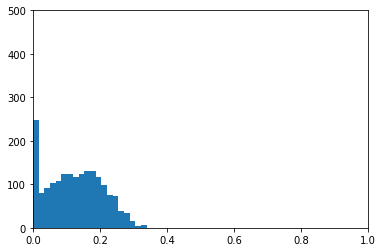




Persona 1
3.517829505236075	it’s more convenient
3.442610984131107	it’s faster
3.283760432811173	it’s cheaper
2.8222508560296458	commuting
2.720192159505101	i want to reduce my environmental impact
2.6918386694671925	chores / errands
2.5299514069718527	transportation
2.333465551357018	it’s more reliable
1.7099418836083167	it’s more fun
1.2191768077723695	work
1.096840527689541	it’s part of my identity/culture
1.0348556168861156	i want to be healthy
0.9940177363409306	temperate
0.8812280778823329	to help me navigate
0.8029264545825443	pleasure rides


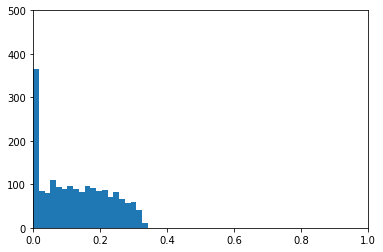




Persona 2
5.033614347649001	safest routes)
5.033614347649001	to help me stay safe (nightlight
2.8017740186642324	to help keep my bike safe
1.2031409805209492	it's not safe for me
0.8366807661596175	to help me navigate
0.7448880739900734	to help me keep track of my environmental goals
0.689701719071494	to help me keep track of my fitness goals
0.591945550262688	it's not safe for my bike
0.5425065757712887	so i don't have to look at my phone while riding
0.5033025058705636	i want to reduce my environmental impact
0.40921596554725514	night
0.2942203206331617	pleasure rides
0.278205055287548	temperate
0.24498088852843797	i don't know the way
0.20281132031787413	i have friends/family who also bike


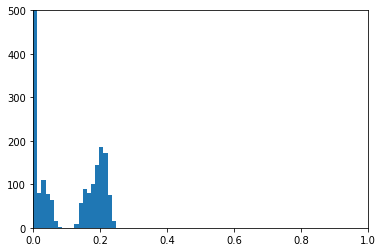




Persona 3
3.6213411755101017	the weather doesn't suit me
2.227205510983612	temperate
2.054752974769779	so i don't have to look at my phone while riding
1.9894178820521489	because it's cool!
1.9860850982826885	to help me navigate
1.8799562868157882	i have to carry things with me
1.728241202483158	i want to be healthy
1.6276501318320322	i feel lazy
1.4479886692559292	the route is too long/steep
1.2846164296728229	pleasure rides
0.9540541370378792	i don't want to sweat
0.841942030242524	commuting
0.7209818564303987	hot/humid
0.7206078614127409	transportation
0.6855793409549641	it's not safe for me


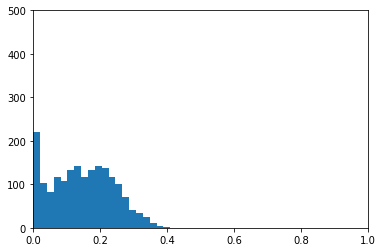




Persona 4
4.729900945655602	rain
4.307727032698456	hot/humid
4.3016563392702665	night
2.371855930356828	snow/ice
1.7954706879036	temperate
1.64924577945693	because it's cool!
1.4651087021880858	i want to be healthy
1.300015708668525	so i don't have to look at my phone while riding
1.2682834302347856	work
1.2199738646547764	to help me navigate
1.1951137350913312	transportation
1.1582600545480513	commuting
1.1318697843321195	pleasure rides
0.9901835428658627	it’s part of my identity/culture
0.666904123094954	i have to carry things with me


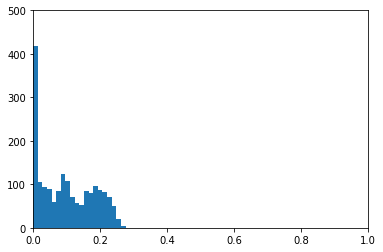

In [124]:
'''
This section extracts the components from the NMF model, allowing us to describe the component in
    a more "human readable" way
'''

# Create a DataFrame: components_df
components_df = pd.DataFrame(model.components_, columns=vec.get_feature_names())

# Print the shape of the DataFrame
print(components_df.shape)

for x in range(0,components_df.shape[0]):
    print("\nPersona "+str(x))
    print("==========")
    component = components_df.iloc[x,:]
    for y,z in component.nlargest(15).items():
        print("{}\t{}".format(z, y))
        
        
    #print(component.nlargest(50))
    plt.hist(df_nmf.iloc[:,x], bins=20)
    plt.ylim(0,500)
    plt.xlim(0,1)
    plt.show()
    print("\n")

### Segment Reverse Analysis

Due to the fact that the segments are based upon behaviour, looking at the segments themselves doesn't tell us much about the makeup of the constituent users.  In this section, we apply the segments to the orginal user list by looking at the affinity of each user to each segment.

#### Segmentation of audiences

For each user, we have an "affinity" to each segment.  This is pretty fuzzy, so using the distribution graphs above, we segment users based on a "normal" population.  i.e. we took the biggest hump on the rightmost side of the graphs for each segment.

In [125]:
# variables we'll use to segment users (these have been eyeballed using the histograms)
#    note that if we change the # of segments, we'll have to change this section
segment_slices = []
segment_slices.append([0.1, 0.2])
segment_slices.append([0.075, 0.25])
segment_slices.append([0.1, 0.3])
segment_slices.append([0.1, 0.25])
segment_slices.append([0.15, 0.225])

#get names for each persona
total_num_users = len(names)

#initalize the lists we'll use
segment_names=[]  #this is a list of names for each persona
no_segment_names=[]
for x in range(0, model.components_.shape[0]):
    segment_names.append([])

#iterate through users and segme
for name,segment_affinities in df_nmf.iterrows():
    #print(segment_affinities)
    is_sorted=False
    for x in range(0,segment_affinities.shape[0]):
        #if segment_affinities[x] >= 0.1:
        if segment_affinities[x] >= segment_slices[x][0] and segment_affinities[x] <= segment_slices[x][1]:
            segment_names[x].append(name)
            is_sorted=True
            
    if not is_sorted:
        no_segment_names.append(name)

for x in range(0, model.components_.shape[0]):
    num_users = len(segment_names[x])
    percent_users = round(num_users/total_num_users*100,1)
    print("There are {}({}%) people in segment {}".format(num_users, percent_users, x))

num_no_segment = len(no_segment_names)
percent_no_segment = round(num_no_segment/total_num_users*100,1)
print("{}({}%) have not been put into a segment".format(num_no_segment, percent_no_segment))
            

There are 738(40.2%) people in segment 0
There are 896(48.8%) people in segment 1
There are 932(50.8%) people in segment 2
There are 955(52.0%) people in segment 3
There are 468(25.5%) people in segment 4
95(5.2%) have not been put into a segment


#### Segment Affinities

Just as we got average affinity for the entire audience, we can do the same for each segment

In [132]:
target_segment = 4
segment_nmf = df_nmf[df_nmf.index.isin(segment_names[target_segment])]

#output averages and std devs for segment
output_av_std = []
for x in range(0, len(col_names)):
    col_name = col_names[x]
    segment_name = SEGMENT_LABEL+" "+str(x)
    av = segment_nmf[col_name].mean()
    std = segment_nmf[col_name].std()
    output_av_std.append([segment_name, av, std])

print("\n{} {} Affinity to All Segments".format(SEGMENT_LABEL, target_segment))
print(pd.DataFrame(output_av_std, columns=["segment", "avg","std dev"]).to_string())


Segment 4 Affinity to All Segments
     segment       avg   std dev
0  Segment 0  0.103545  0.073694
1  Segment 1  0.175465  0.090502
2  Segment 2  0.114567  0.090448
3  Segment 3  0.094397  0.080694
4  Segment 4  0.187110  0.021445


#### Reverse Audit

At this point, we have lists of users in each segment.  Now we can use the original dataframe (from the Importing, cleaning, and wrangling data Section) to see what else these users have in common

In [133]:
#vars
precision = 2
output_data = []
target_segment = 4 #this is also defined above

# for segment
segment_df = df[df.token.isin(segment_names[target_segment])]

for category in catcol:
    all_values = df[category].value_counts(normalize=True, sort=False)
    segment_values = segment_df[category].value_counts(normalize=True, sort=False)

    for i in range(0, len(all_values)):
        label = "{}:{}".format(category,all_values.index[i]) 
        cat_diff = round((segment_values[i]-all_values[i])/all_values[i]*100, precision)
        formatted_all = round(all_values[i]*100, precision)
        formatted_segment = round(segment_values[i]*100, precision)
        
        output_data.append([label, formatted_all, formatted_segment, cat_diff])

print(pd.DataFrame(output_data, columns=['category', '% All', "% segment {}".format(target_segment), '% difference']).to_string())

                                              category  % All  % segment 4  % difference
0                                       age:0-25 years   6.05         6.62          9.56
1                                      age:25-34 years  27.83        29.27          5.18
2                                      age:35-44 years  28.38        32.26         13.70
3                                      age:45-45 years   3.05         3.42         12.09
4                                      age:45-54 years  17.43        16.67         -4.38
5                                        age:55+ years  17.27        11.75        -31.93
6                                        gender:Female  14.05        11.11        -20.93
7                                          gender:Male  84.80        86.97          2.55
8                                    gender:Non-binary   0.60         0.64          6.99
9                             gender:Prefer not to say   0.54         1.28        135.38
10                   

# TODO: figure out how to consume bike_type, companions, accessory_channels which are all multi-select
# TODO: figure out how to comsume the info from the segmentation: conditions, activities, reasons to bike, reasons not to bike, reasons for smarthalo

In [138]:
# get the segment dataframe
target_segment = 4 #this is also defined above
segment_df = df[df.token.isin(segment_names[target_segment])]
segment_count = segment_df.shape[0]
all_count = df.shape[0]
output_data = []


def output_multi_select_counts(option_list, segment_df, all_df, column_name):
    output_data = []
    segment_row_count = segment_df.shape[0]
    all_row_count = all_df.shape[0]
    
    for x in range(0, len(option_list)):
        option = option_list[x]
        segment_count = 0
        segment_percent = 0
        all_count = 0
        all_percent = 0
        difference_percent = 0
        
        #if we have the values, fill them in, otherwise use the zeroes above
        try:
            all_count = all_df[column_name].str.contains(option).value_counts()[True]
            all_percent = round(all_count/all_row_count*100, 2)
            segment_count = segment_df[column_name].str.contains(option).value_counts()[True]
            segment_percent = round(segment_count/segment_row_count*100, 2)
            difference_percent = round((segment_percent-all_percent)/all_percent*100,2)
        except KeyError: 
            pass
        
        output_data.append([option, all_count, segment_count, all_percent, segment_percent, difference_percent])
        
    print(pd.DataFrame(output_data, columns=[column_name, 'all count', 'segment count', "all %", "segment %", "difference %"]).to_string())
    

'''
The following values are just grabbed from the surveys.  I could probably use a CountVectorizer to do it in a more scalable way
'''

bike_types = ['Road bike', 'Mountain bike', 'Hybrid bike', 'Bike share bike', 'E-bike', 'Cruiser / City bike', 'Cargo bike', 'Single-speed bike', 'Gravel bike']
companions = ['I bike alone', 'With family and friends', 'With young children', 'With a riding pack']
conditions = ['Temperate', 'Hot/Humid', 'Rain', 'Snow/Ice', 'Night']
activities = ['Commuting', 'Chores / Errands', 'Work', 'Transportation', 'Mountain biking', 'Touring', 'Racing', 'Fitness', 'BMX', 'Pleasure rides']
reasons_to_bike = ['convenient', 'reliable', 'faster', 'cheaper', 'environment', 'healthy', 'friends/family', 'hobby/interest', 'identity/culture', 'more fun']
reasons_to_not_bike = ['weather', 'long/steep', 'don\'t know the way', 'have to carry things', 'don\'t want to sweat', 'not safe for me', 'not safe for my bike', 'feel lazy', 'wouldn\'t be fun', 'too dark']
reason_for_smarthalo = ['navigate', 'keep track of my fitness goals', 'keep track of my environmental goals', 'stay safe', 'keep my bike safe', 'don\'t have to look at my phone', 'it\'s cool!']
accessory_channels = ['Online forums', 'Social media', 'Amazon/e-commerce', 'Chats with friends or family', 'Retail stores']

# output

print("{} {}\n===============\n\n".format(SEGMENT_LABEL, target_segment))

output_multi_select_counts(bike_types, segment_df, df, "bike_type")
print("\n")
output_multi_select_counts(companions, segment_df, df, "companions")
print("\n")
output_multi_select_counts(conditions, segment_df, df, "conditions")
print("\n")
output_multi_select_counts(activities, segment_df, df, "activities")
print("\n")
output_multi_select_counts(reasons_to_bike, segment_df, df, "reasons_to_bike")
print("\n")
output_multi_select_counts(reasons_to_not_bike, segment_df, df, "reasons_to_not_bike")
print("\n")
output_multi_select_counts(reason_for_smarthalo, segment_df, df, "reason_for_smarthalo")
print("\n")
output_multi_select_counts(accessory_channels, segment_df, df, "accessory_channels")


Segment 4


             bike_type  all count  segment count  all %  segment %  difference %
0            Road bike        797            199  43.41      42.52         -2.05
1        Mountain bike        529            132  28.81      28.21         -2.08
2          Hybrid bike        450            122  24.51      26.07          6.36
3      Bike share bike        140             54   7.63      11.54         51.25
4               E-bike        285             72  15.52      15.38         -0.90
5  Cruiser / City bike        437            125  23.80      26.71         12.23
6           Cargo bike         74             28   4.03       5.98         48.39
7    Single-speed bike        174             50   9.48      10.68         12.66
8          Gravel bike        199             67  10.84      14.32         32.10


                companions  all count  segment count  all %  segment %  difference %
0             I bike alone       1553            434  84.59      92.74          9.63
1  Wit